LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance 에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가

In [1]:
!pip install tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [3]:
raw_df = pd.read_csv('./20220302_20220315_100.csv')  # yahoo finance 로부터 데이터 다운로드

raw_df

,Unnamed: 0,1_한성여객종점,2_노원평생학습관,3_서울시립북서울미술관,4_중계역,5_중계역2번출구,6_중계3단지목련아파트,7_목련아파트상가,8_중계목화아파트4단지,9_노원경찰서,...,113_대진고등학교,114_서울온천,115_노원경찰서.혜성여고,116_하계현대아파트,117_롯데마트,118_상명초등학교,119_중계건영2차아파트,120_중계역,121_하계한신청구아파트,122_한성여객종점
0,2022-03-02 04:00:00,4,0,2,4,4,8,11,13,16,...,0,0,0,0,0,0,0,0,0,0
1,2022-03-02 05:00:00,0,0,0,1,2,2,2,4,8,...,0,0,0,0,0,0,0,0,0,0
2,2022-03-02 06:00:00,0,0,2,1,3,5,8,12,17,...,4,3,2,1,0,0,0,0,0,0
3,2022-03-02 07:00:00,1,1,6,8,14,10,13,20,23,...,24,14,8,7,5,2,1,0,0,0
4,2022-03-02 08:00:00,1,1,2,1,8,9,14,15,19,...,15,12,8,7,5,4,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2022-03-15 23:00:00,0,0,0,0,0,0,0,0,0,...,6,4,2,2,1,0,0,1,0,0
332,2022-03-16 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
333,2022-03-16 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334,2022-03-16 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


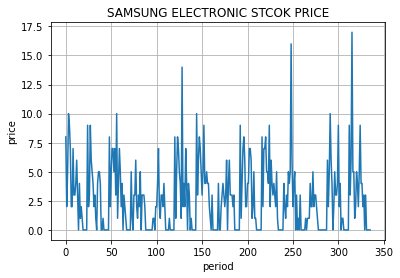

In [5]:
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['6_중계3단지목련아파트'], label='Adj Close')

plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [8]:
# 통계정보 확인

raw_df.describe()

,1_한성여객종점,2_노원평생학습관,3_서울시립북서울미술관,4_중계역,5_중계역2번출구,6_중계3단지목련아파트,7_목련아파트상가,8_중계목화아파트4단지,9_노원경찰서,10_하계1동주민센터,...,113_대진고등학교,114_서울온천,115_노원경찰서.혜성여고,116_하계현대아파트,117_롯데마트,118_상명초등학교,119_중계건영2차아파트,120_중계역,121_하계한신청구아파트,122_한성여객종점
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,...,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.0
mean,0.336310,0.279762,1.229167,1.464286,2.755952,2.761905,4.886905,5.770833,8.181548,8.720238,...,7.205357,5.630952,3.854167,2.660714,1.785714,1.205357,0.630952,0.255952,0.032738,0.0
std,0.747128,0.681750,1.610927,1.922041,2.662054,2.911097,3.694975,4.785973,6.442380,7.384878,...,6.130625,4.646372,3.261652,2.550576,1.794329,1.540334,0.933998,0.567761,0.209048,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.750000,4.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,1.000000,1.000000,3.000000,2.000000,5.000000,6.000000,8.000000,8.000000,...,7.000000,6.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,7.000000,8.250000,11.000000,12.000000,...,11.000000,9.000000,6.000000,4.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.0
max,5.000000,4.000000,15.000000,16.000000,17.000000,17.000000,20.000000,22.000000,31.000000,34.000000,...,24.000000,21.000000,15.000000,12.000000,9.000000,7.000000,6.000000,3.000000,2.000000,0.0


In [9]:
# Missing Data 확인

raw_df.isnull().sum()

Unnamed: 0       0
1_한성여객종점         0
2_노원평생학습관        0
3_서울시립북서울미술관     0
4_중계역            0
                ..
118_상명초등학교       0
119_중계건영2차아파트    0
120_중계역          0
121_하계한신청구아파트    0
122_한성여객종점       0
Length: 123, dtype: int64

In [10]:
# 최소값이 0 인 column 체크

for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

1_한성여객종점 <class 'str'>
2_노원평생학습관 <class 'str'>
3_서울시립북서울미술관 <class 'str'>
4_중계역 <class 'str'>
5_중계역2번출구 <class 'str'>
6_중계3단지목련아파트 <class 'str'>
7_목련아파트상가 <class 'str'>
8_중계목화아파트4단지 <class 'str'>
9_노원경찰서 <class 'str'>
10_하계1동주민센터 <class 'str'>
11_골마을근린공원 <class 'str'>
12_하계역 <class 'str'>
13_하계우성아파트 <class 'str'>
14_하계극동아파트 <class 'str'>
15_월계보건지소 <class 'str'>
16_인덕대학 <class 'str'>
17_월계주공108동앞롯데캐슬루나아파트 <class 'str'>
18_오현초등학교 <class 'str'>
19_꿈의숲주차장입구 <class 'str'>
20_북서울꿈의숲 <class 'str'>
21_송중동한일유엔아이 <class 'str'>
22_창문여고앞 <class 'str'>
23_숭곡초등학교입구 <class 'str'>
24_월곡뉴타운 <class 'str'>
25_길음뉴타운 <class 'str'>
26_미아리고개.미아리예술극장 <class 'str'>
27_돈암사거리.성신여대입구 <class 'str'>
28_삼선교.한성대학교 <class 'str'>
29_혜화동로터리.여운형활동터 <class 'str'>
30_명륜3가.성대입구 <class 'str'>
31_창경궁.서울대학교병원 <class 'str'>
32_원남동 <class 'str'>
33_광장시장 <class 'str'>
34_을지로4가 <class 'str'>
35_을지로3가 <class 'str'>
36_을지로2가.기업은행본점.서울노동청 <class 'str'>
37_롯데백화점 <class 'str'>
38_북창동.남대문시장 <class 'str'>
39_숭례문(가상) <class 'str'>
40_숭례문 

In [11]:
raw_df.loc[raw_df['Volume']==0]

KeyError: 'Volume'

In [6]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Unnamed: 0: 0
1_한성여객종점: 256
2_노원평생학습관: 276
3_서울시립북서울미술관: 131
4_중계역: 132
5_중계역2번출구: 83
6_중계3단지목련아파트: 109
7_목련아파트상가: 70
8_중계목화아파트4단지: 79
9_노원경찰서: 72
10_하계1동주민센터: 77
11_골마을근린공원: 70
12_하계역: 71
13_하계우성아파트: 70
14_하계극동아파트: 72
15_월계보건지소: 70
16_인덕대학: 70
17_월계주공108동앞롯데캐슬루나아파트: 70
18_오현초등학교: 70
19_꿈의숲주차장입구: 73
20_북서울꿈의숲: 72
21_송중동한일유엔아이: 73
22_창문여고앞: 71
23_숭곡초등학교입구: 70
24_월곡뉴타운: 65
25_길음뉴타운: 62
26_미아리고개.미아리예술극장: 62
27_돈암사거리.성신여대입구: 63
28_삼선교.한성대학교: 62
29_혜화동로터리.여운형활동터: 72
30_명륜3가.성대입구: 59
31_창경궁.서울대학교병원: 86
32_원남동: 65
33_광장시장: 76
34_을지로4가: 67
35_을지로3가: 59
36_을지로2가.기업은행본점.서울노동청: 61
37_롯데백화점: 59
38_북창동.남대문시장: 83
39_숭례문(가상): 168
40_숭례문: 85
41_서울역버스환승센터: 63
42_갈월동: 71
43_숙대입구역: 69
44_삼각지역: 71
45_KT용산지사: 91
46_신용산역: 72
47_한강대교북단.LG유플러스: 70
48_이촌동동부센트레빌: 78
49_이촌1동충신교회앞: 72
50_이촌동한강맨션.이촌역: 73
51_신용산초등학교: 75
52_이촌동점보아파트: 77
53_금강병원.반도아파트: 77
54_서빙고신동아아파트: 80
55_서빙고역1번출구: 76
56_한강중학교: 88
57_용산구청.크라운호텔: 93
58_용산구청.크라운호텔: 113
59_한강중학교: 135
60_금호베스트빌앞: 205
61_서빙고초등학교: 259
62_서빙고역교차로: 173
63_서빙고역1번출구: 97
64_

In [11]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


In [12]:
# missing data 확인

raw_df.isnull().sum()

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [13]:
raw_df.isnull().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
3MA           True
5MA           True
dtype: bool

In [14]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [15]:
# missing data 처리

raw_df = raw_df.dropna()

raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [7]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = list(raw_df.columns)
del columns[0]
scale_cols = list(columns)

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

     1_한성여객종점  2_노원평생학습관  3_서울시립북서울미술관   4_중계역  5_중계역2번출구  6_중계3단지목련아파트  \
0         0.8       0.00      0.133333  0.2500   0.235294      0.470588   
1         0.0       0.00      0.000000  0.0625   0.117647      0.117647   
2         0.0       0.00      0.133333  0.0625   0.176471      0.294118   
3         0.2       0.25      0.400000  0.5000   0.823529      0.588235   
4         0.2       0.25      0.133333  0.0625   0.470588      0.529412   
..        ...        ...           ...     ...        ...           ...   
331       0.0       0.00      0.000000  0.0000   0.000000      0.000000   
332       0.0       0.00      0.000000  0.0000   0.000000      0.000000   
333       0.0       0.00      0.000000  0.0000   0.000000      0.000000   
334       0.0       0.00      0.000000  0.0000   0.000000      0.000000   
335       0.0       0.00      0.000000  0.0000   0.000000      0.000000   

     7_목련아파트상가  8_중계목화아파트4단지   9_노원경찰서  10_하계1동주민센터  ...  113_대진고등학교  \
0         0.55      0.59090

주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
 - 정답은 Adj Close 선정
 - 시계열 데이터를 위한 window_size = 40 선정

In [11]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [33]:
# feature_df, label_df 생성

feature_cols = ['2_노원평생학습관', '3_서울시립북서울미술관', '4_중계역', '5_중계역2번출구', '6_중계3단지목련아파트', '7_목련아파트상가', '8_중계목화아파트4단지']
label_cols = [ '6_중계3단지목련아파트' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [34]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(336, 7) (336, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [35]:
window_size =24

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(312, 24, 7) (312, 1)


학습데이터, 테스트데이터 생성

In [36]:
# train, test 분리

#split = int(len(X)*0.95)
split = -24

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(288, 24, 7) (288, 1)
(24, 24, 7) (24, 1)


모델 구축 및 컴파일

In [38]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [39]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               69632     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
18/18 [==============================] - 2s 38ms/step - loss: 0.0306 - mae: 0.1354 - val_loss: 0.0540 - val_mae: 0.1477
Epoch 2/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0222 - mae: 0.1117 - val_loss: 0.0514 - val_mae: 0.1459
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0198 - mae: 0.1013 - val_loss: 0.0483 - val_mae: 0.1525
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0202 - mae: 0.1041 - val_loss: 0.0483 - val_mae: 0.1512
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0201 - mae: 0.1013 - val_loss: 0.0478 - val_mae: 0.1496
Epoch 6/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0192 - mae: 0.0987 - val_loss: 0.0462 - val_mae: 0.1488
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0184 - mae: 0.0994 - val_loss: 0.0505 - val_mae: 0.1384
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.

예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

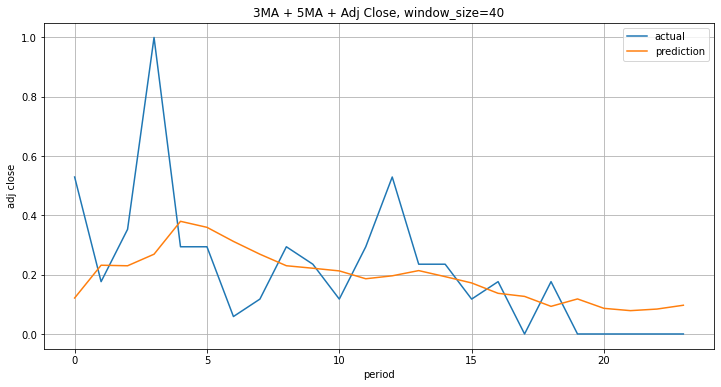

In [41]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [32]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.02175000971541701
